In [17]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
import math

/Users/alviseperosa/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/alviseperosa/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[12.02925325  2.67712151]


100%|██████████████████████████████████████| 5000/5000 [00:15<00:00, 324.25it/s]
/Users/alviseperosa/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(150400, 2)
[12.10782303  2.79772683]


100%|██████████████████████████████████████| 5000/5000 [00:15<00:00, 331.00it/s]


(150400, 2)
[12.26734258  3.06711229]


100%|██████████████████████████████████████| 5000/5000 [00:15<00:00, 330.40it/s]


(150400, 2)
[12.41959521  3.31349603]


100%|██████████████████████████████████████| 5000/5000 [00:15<00:00, 328.64it/s]


(150400, 2)
[12.62367837  3.56817368]


100%|██████████████████████████████████████| 5000/5000 [00:15<00:00, 322.15it/s]


(150400, 2)


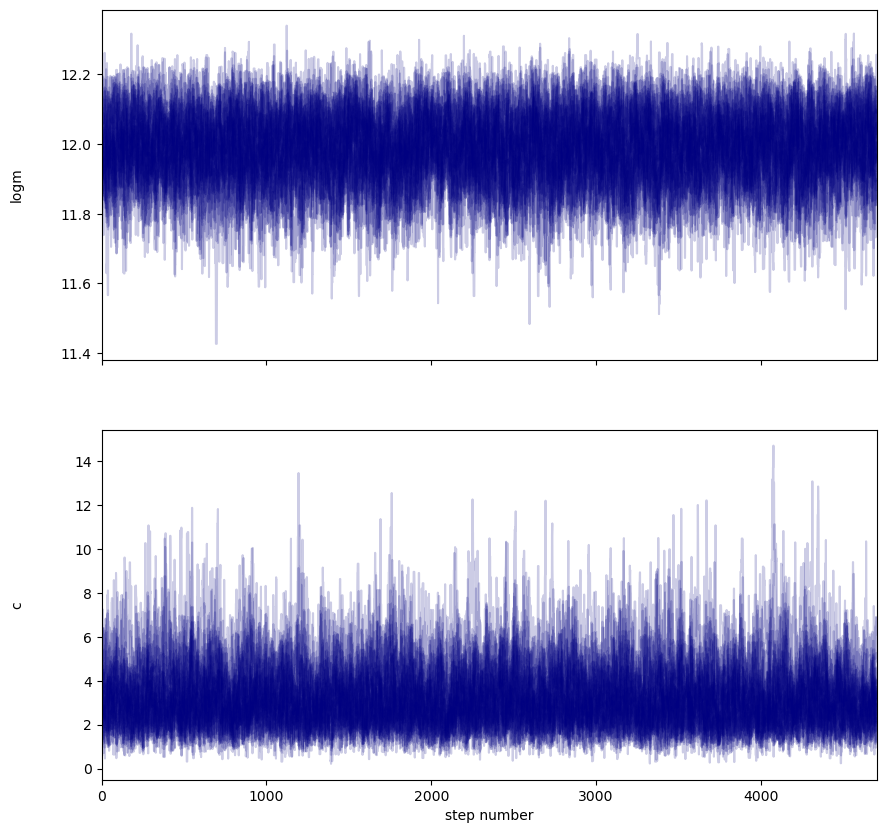

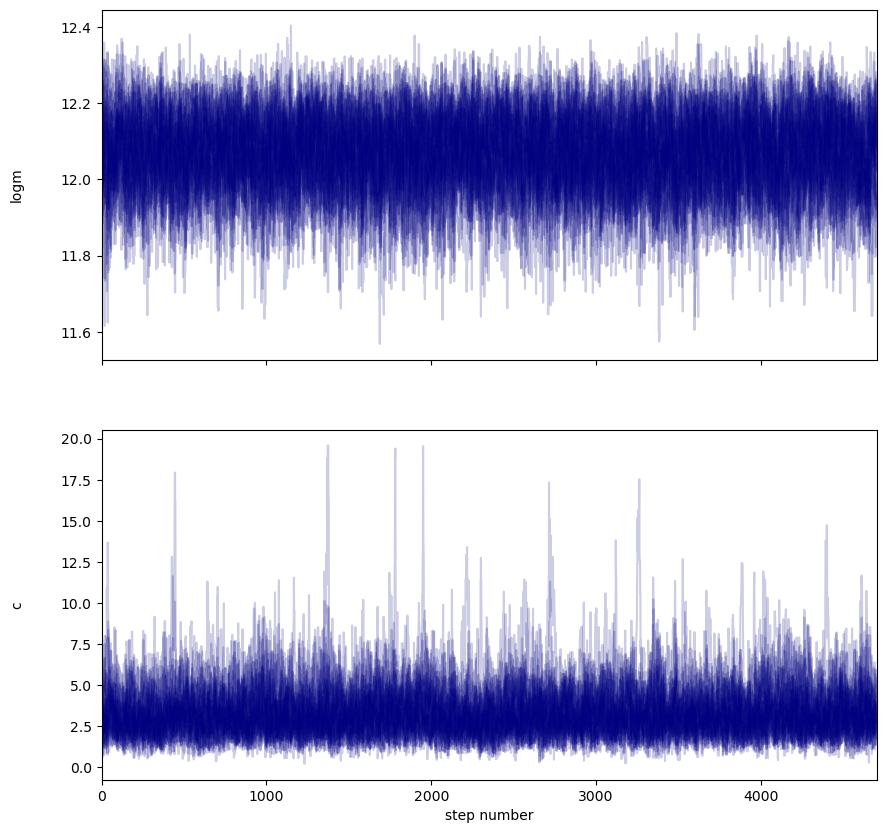

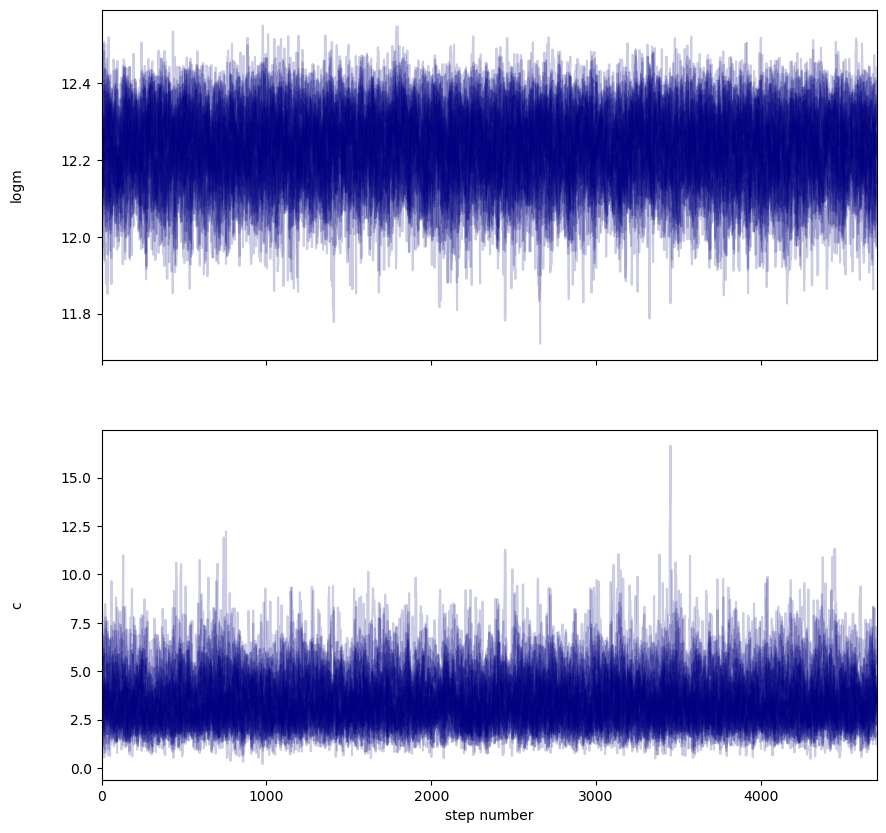

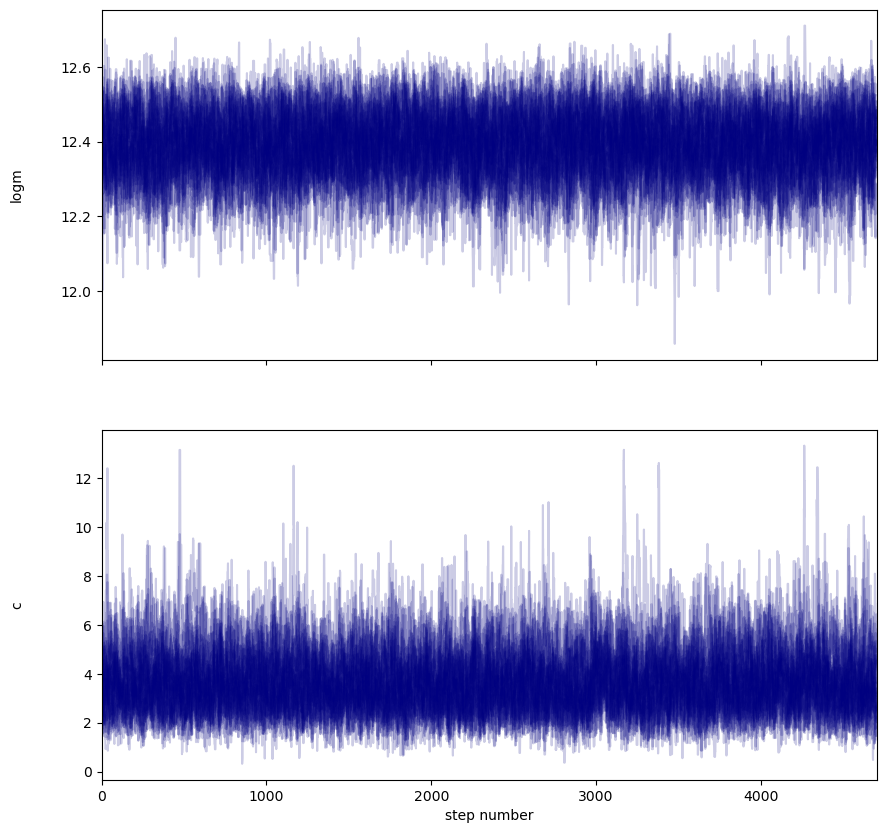

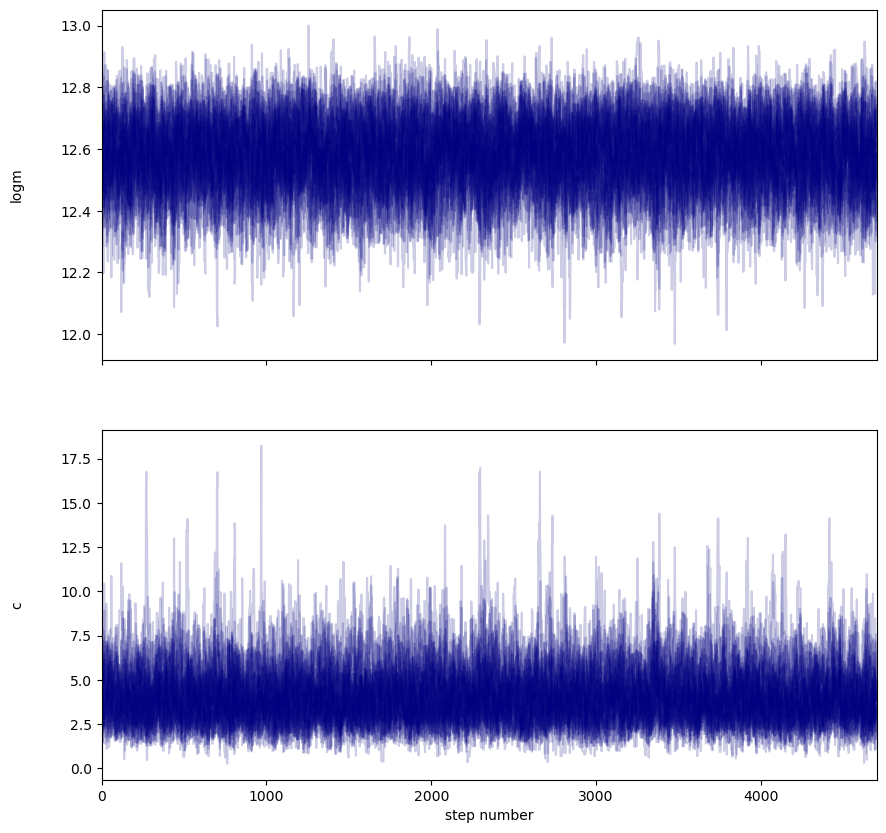

In [73]:
from astropy.table import Table
def nfw(R, M, c, z):
    # Definisco i valori che mi serviranno poi per la funzione sigma
    
    ro_m = 0.286 * (2.7751428946 * 10**11) * 0.7**2
    f_c = math.log(1 + c) - (c / (1 + c))
    delta_c= 200 * c**3 / (3 * f_c)
    ro_s = ro_m * delta_c * (1 + z)**3
    r_s =  1 / c *((3 * M / (4 * np.pi * ro_m* ((1 + z)**3))) ** (1 / 3))
    
    # Calcolo della funzione f(x) 
    x = R / r_s
    f_x = np.zeros_like(x)
    
    # faccio un ciclo for che itera su una sequenza di numeri interi, 
    #partendo da 0 fino a un numero pari alla lunghezza della lista x. In questo caso, x è 
    #un array numpy, e len(x) restituisce la lunghezza di tale array.
    
    for i in range (len(x)):
      if(x[i]<=1):
        f_x[i]=(1-(2*np.arctanh(math.sqrt((1-x[i])/(1+x[i]))))/(math.sqrt(1-x[i]**2)))/(x**2-1)[i]
      elif(x[i]==1):
        f_x[i]=1/3
      else:
        f_x[i]=(1-(2*np.arctan(math.sqrt((x[i]-1)/(1+x[i]))))/(math.sqrt(x[i]**2-1)))/(x**2-1)[i]

    # infine mettendo tutte le variabili assieme e ottengo la fuznione sigma 
    Sigma = 2 * f_x * r_s * ro_s

    return Sigma




# Ora definiamo la funzione di Likelihood del modello
# Il profilo di densità viene calcolato con la NFW definita sopra
def log_likelihood(theta, r, data, cov_matrix, z):
    logM, c = theta
    M = 10**(logM)
    model = nfw(r, M, c, z)
    diff = data - model
    cov_inv = np.linalg.inv(cov_matrix)
    return -0.5 * np.dot(diff, np.dot(cov_inv, diff))

# Definiamo la log-prior: implementa un prior piatto (uniforme) sui parametri da stimare logM e c.
# Restituisce 0 se i parametri sono nel range definito e -np.inf altrimenti.
def log_prior(theta):
    logM, c = theta
    if 10.0 <= logM <= 16.0 and 0.2 <= c <= 20.0: #io per logm per farlo venire bene metterei un intervallo tra 10 e 16 ma nella consegna chiede 13
        return 0.0
    return -np.inf

# Ora definiamo la log-posterior: è la somma del log-prior e del log-likelihood.
# Se il log-prior è infinito, la log-posterior diventa infinitamente negativa.
def log_posterior(theta, r, data, cov_matrix, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, data, cov_matrix, z)

results = np.ndarray((5,150400,2))
bestfit=[]
# Carichiamo i dati richiesti
tab = 'halo_catalog.fit'
catalog_data = fits.getdata(tab)
ricchezza = catalog_data['LAMBDA_TR']
profilo_densita = catalog_data['SIGMA_of_R']
R_values = np.load('R_values.npy')
cov_matrix = np.load('covariance_matrices.npy')


intervalli = np.array([15, 20, 30, 45, 60, 200])
# Inizializziamo degli array per mettere i risultati ad ogni gruppo
results = np.ndarray((5,150400,2)) 
bestfit = np.ndarray ((5,2))
   #bestfit = np.ndarray ((5,2)) # due parametri stimati per ogni gruppo di ricchezza

# Suddividiamo il catalogo in base agli intervalli, come prima
for i in range(5):
    if i < 4:
        gruppo = catalog_data[(ricchezza >= intervalli[i]) & (ricchezza < intervalli[i + 1])]
    else:
        gruppo = catalog_data[(ricchezza >= intervalli[i])]
    redshift_medio = np.mean(gruppo['Z'])
    profili_densita_gruppo = gruppo['SIGMA_of_R']

 
    sigma_medio = np.mean(profili_densita_gruppo, axis=0)
    deviazione_standard = np.std(profili_densita_gruppo, axis=0)

    #print(sigma_medio)
    
    nll = lambda *args: -log_posterior(*args)

#Parametri iniziali
    initial = np.array([13.5, 0.5]) * (1 + 0.01 * np.random.randn(2))
#Minimizzazione per il singolo gruppo perche ho messo il meno prima
    soln = minimize(nll, initial, args=(R_values, sigma_medio, cov_matrix[i], redshift_medio))
    logM_b, c_b = soln.x
    bestfit[i] = soln.x
    print(soln.x) #cosi vedo se stampa 5 vaplte 2 valori che minimizzano
    
#Moltiplica il vettore dei parametri ottimizzati per un valore,
#Questo introduce una piccola variazione ai parametri ottimizzati
    pos = soln.x *(1+ 1e-4 * np.random.randn(32, 2)) 

#print(pos.shape )                                  
    nwalkers, ndim = pos.shape 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(R_values, sigma_medio, cov_matrix[i], redshift_medio))
    sampler.run_mcmc(pos, 5000, progress=True);
    
    flat_samples = sampler.get_chain(discard=300, flat=True)
    print(flat_samples.shape)
    results[i] = flat_samples #è utile per salvare i campioni estratti dalla catena MCMC per il gruppo corrente
    #print(results[i])
    
    
    fig, axes = plt.subplots(2, figsize=(10, 10), sharex=True)
    samples = sampler.get_chain()
    labels = ["logm", "c"]
    burn_in = 300  # Numero di passi di burn-in da scartare

    for j in range(ndim): # itera attraverso i due parametri
        ax = axes[j] # assegna il subplot corrente alla variabile ax
        ax.plot(samples[burn_in:, :, j], "navy", alpha=0.2)  # Ignora i primi 300 passi
        ax.set_xlim(0, len(samples) - burn_in)  # Aggiorna i limiti dell'asse x
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("step number")
   
    
plt.show()
       
    

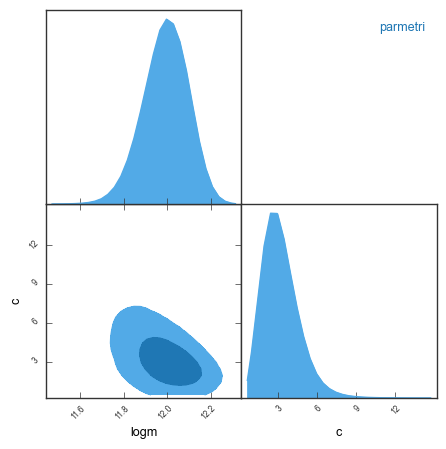

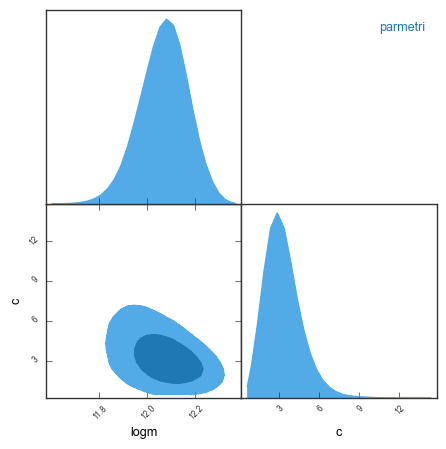

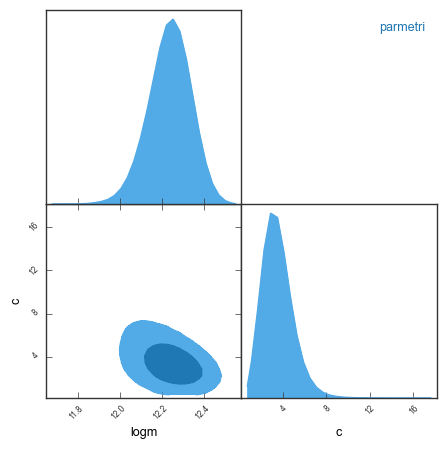

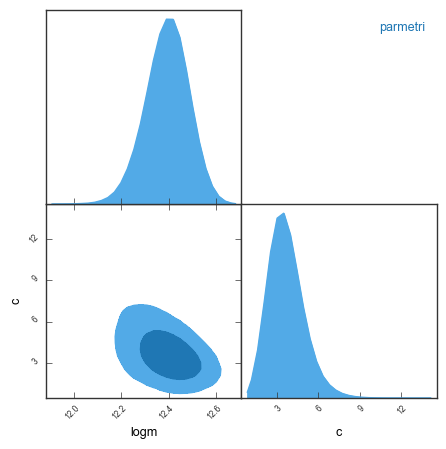

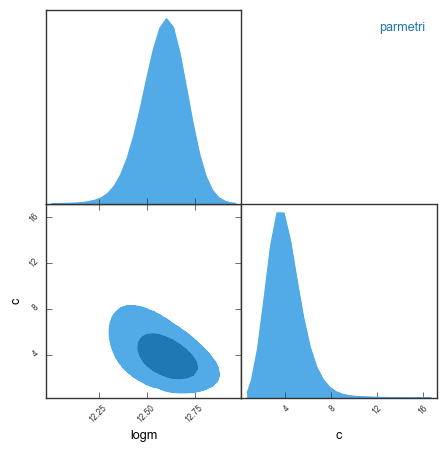

In [24]:
!pip install pygtc
import pygtc

for i in range(5):
    
    GTC = pygtc.plotGTC(chains=results[i],
                    paramNames=['logm','c'],
                    chainLabels=['parmetri'],
                    figureSize='MNRAS_page')
   

In [25]:
!pip install corner
import corner 

In [26]:
for i in range(5):
    mean_params = np.mean(results[i], axis=0)
    std_params = np.std(results[i], axis=0)
    print("Intervallo di ricchezza:", intervalli[i], "-", intervalli[i+1])
    print("medie:", mean_params)
    print("errore:", std_params)
    print("best fit MCMC:", bestfit[i])
    print()  # Aggiunge una riga vuota per separare i risultati degli intervalli

Intervallo di ricchezza: 15 - 20
medie: [11.99077989  3.19815379]
errore: [0.09909444 1.3557358 ]
best fit MCMC: [12.02925353  2.6771155 ]

Intervallo di ricchezza: 20 - 30
medie: [12.06919139  3.2739898 ]
errore: [0.09723436 1.30683382]
best fit MCMC: [12.10782301  2.79772698]

Intervallo di ricchezza: 30 - 45
medie: [12.23363588  3.49867503]
errore: [0.09542256 1.31007424]
best fit MCMC: [12.26734264  3.06711219]

Intervallo di ricchezza: 45 - 60
medie: [12.3918674   3.66022668]
errore: [0.08696183 1.21552563]
best fit MCMC: [12.4195952   3.31349576]

Intervallo di ricchezza: 60 - 200
medie: [12.5869683   4.01175993]
errore: [0.11118457 1.42644983]
best fit MCMC: [12.62367837  3.56817384]



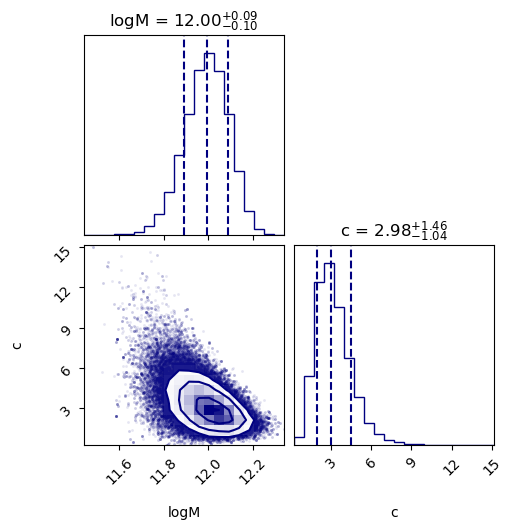

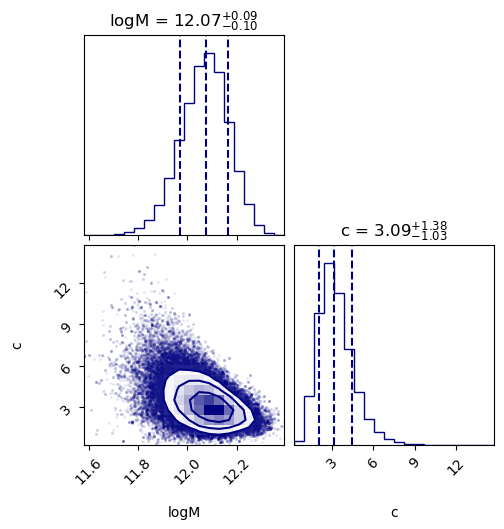

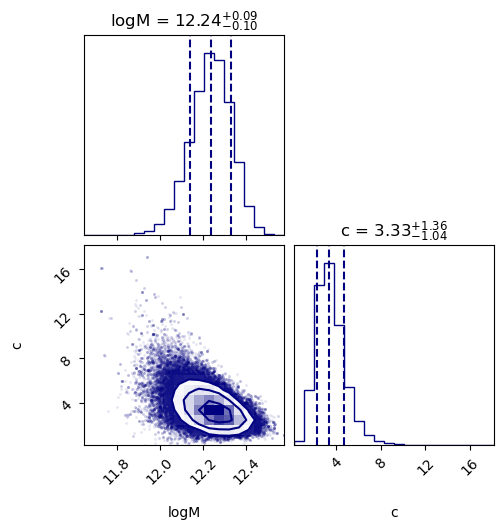

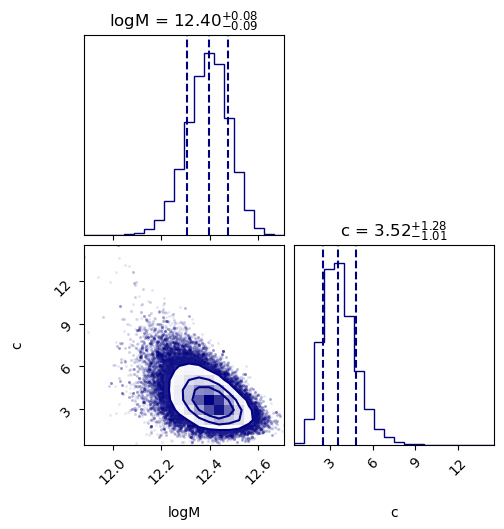

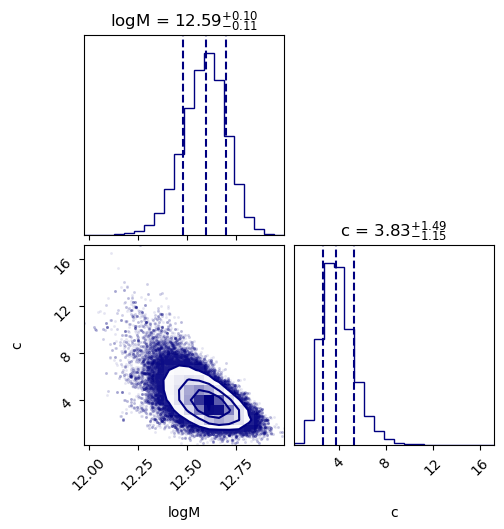

In [72]:
#Per ogni intervallo, genera il grafico triangolare sta volta con la libreria corner
for i in range(5):
    # Estrai i campioni MCMC per il gruppo corrente
    flat_samples = results[i]
    
    # Esegui la visualizzazione con corner
    fig = corner.corner(flat_samples, labels=["logM", "c"], quantiles=[0.16, 0.5, 0.84],color='navy', show_titles=True)
    plt.show()
    
    

In [30]:
predictions_per_interval = []

#faccio copia incolla della altra parte dell esame che avevo gia scritto


tabella = Table.read('halo_catalog.fit')
dati_divisi = []
redshift_medi = []
sigma_medi = []
deviazione_standard = []
sigma_var=[]
# Dividi i dati in base agli intervalli di LAMBDA_TR
for i in range(len(intervalli) - 1):
    lower_bound = intervalli[i]
    upper_bound = intervalli[i + 1]
    
    # Seleziona i dati all'interno dell'intervallo corrente
    dati_intervallo = tabella[(tabella['LAMBDA_TR'] >= lower_bound) & (tabella['LAMBDA_TR'] < upper_bound)]
    redshift_medio = dati_intervallo['Z'].mean()
    redshift_medi.append(redshift_medio)
    colonne_sigma = np.vstack(dati_intervallo['SIGMA_of_R'])
    valori_medisigma = np.mean(colonne_sigma, axis=0)
    sigma_medi.append(valori_medisigma)
    valori_std = np.std(colonne_sigma, axis=0)
    sigma_var.append(valori_std)
   
    
    #print ("Valori medi di densitaà:",valori_medisigma)
    #print ("valori delle deviazioni standard:",valori_std)
    print("\n")
 
    logM_best_fit, c_best_fit = bestfit[i]
    predictions = nfw(R_values, 10**logM_best_fit, c_best_fit, redshift_medio)
    predictions_per_interval.append(predictions)
    #print(predictions)
    
    #print (predictions)
    differenza=predictions-valori_medisigma
    chi2=sum((differenza)**2/(valori_std)**2)
    

    print (chi2)
    



0.4689083517569063


0.37731815389456796


0.2171730330045043


0.13750379094592263


0.05399043520840603


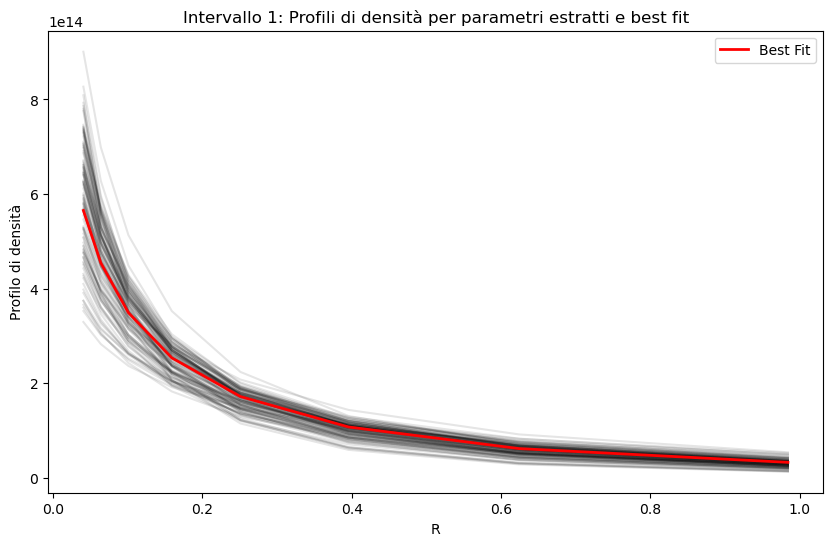

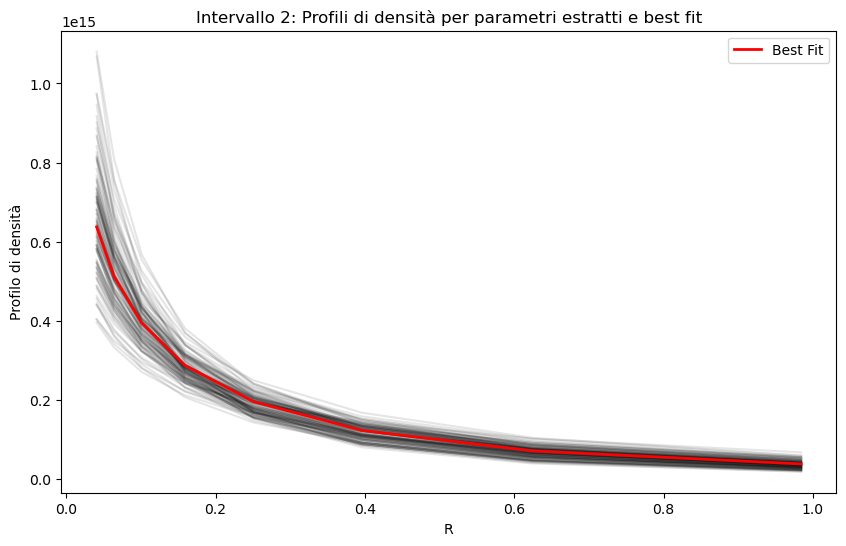

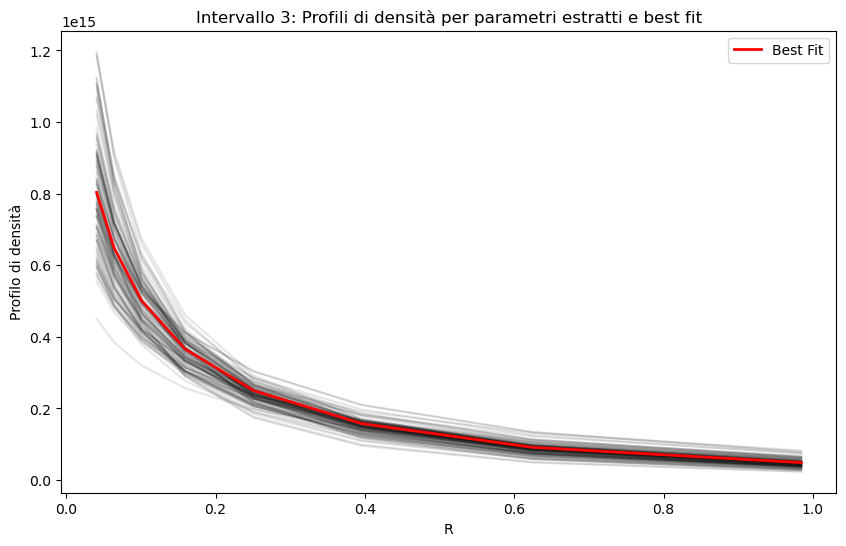

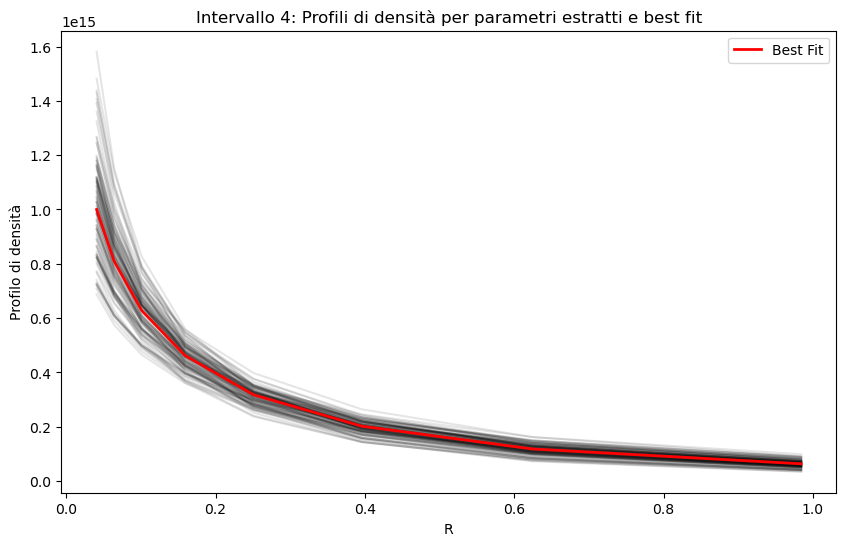

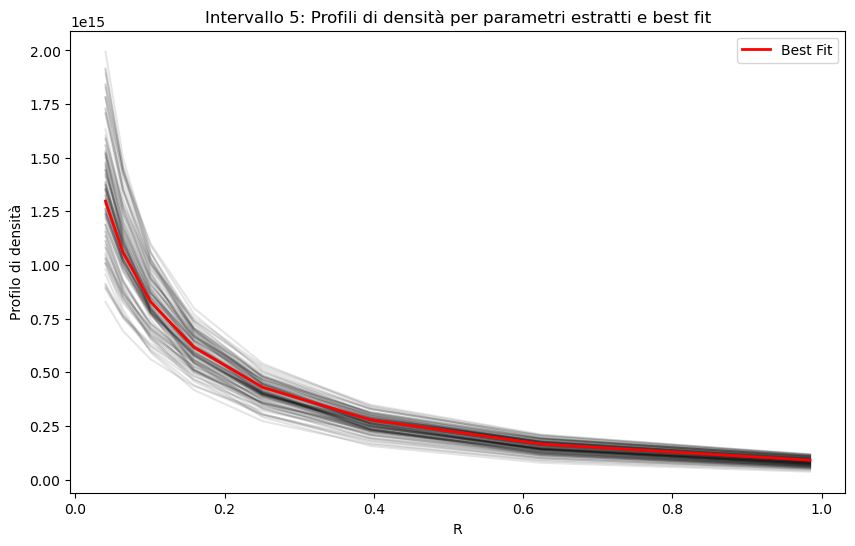

In [70]:
#seleziono a caso 100 valori dalla catena
num_campioni_da_catturare = 100

# Inizializza un array per memorizzare le coppie di parametri estratti
parametri_estratti = np.zeros((len(results), num_campioni_da_catturare, 2))

# Estrai casualmente 100 coppie di parametri da ciascun intervallo di ricchezza
for i in range(len(results)):
    # Estrai casualmente 100 indici unici dai campioni MCMC
    indici_campioni = np.random.choice(results[i].shape[0], num_campioni_da_catturare, replace=False)
    # Memorizza le coppie di parametri estratti
    parametri_estratti[i] = results[i][indici_campioni]

#print(parametri_estratti)

risultati_nfw_estratti = np.zeros((len(intervalli) - 1, num_campioni_da_catturare, len(R_values)))

# Calcola la funzione nfw per i parametri estratti
for i in range(len(intervalli) - 1):
    for j in range(num_campioni_da_catturare):
        # Ottieni i valori di M e c dalla matrice parametri_estratti
        logM, c = parametri_estratti[i, j]
        # Calcola il profilo di densità atteso con la funzione NFW
        profilo_densita = nfw(R_values, 10**logM, c, redshift_medi[i])
        # Memorizza il profilo di densità atteso
        risultati_nfw_estratti[i, j] = profilo_densita
    
#print(risultati_nfw_estratti.shape)  viene che è giustamente (5, 100, 8)

for i in range(len(intervalli) - 1):
    # Estrai i risultati della funzione nfw per i parametri estratti e i valori di best fit
    profili_estratti = risultati_nfw_estratti[i]
    profilo_best_fit = predictions_per_interval[i]
    
    # Crea un nuovo plot
    plt.figure(figsize=(10, 6))
    
    # Plot dei profili di densità per i parametri estratti
    for j in range(num_campioni_da_catturare):
        plt.plot(R_values, profili_estratti[j], color='k', alpha=0.1)  # Utilizza alpha per trasparenza
    
    # Plot del profilo di densità per i valori di best fit
    plt.plot(R_values, profilo_best_fit, color='red', label='Best Fit',linewidth=2)
    
    # Etichette degli assi e titolo
    plt.xlabel('R')
    plt.ylabel('Profilo di densità')
    plt.title(f'Intervallo {i+1}: Profili di densità per parametri estratti e best fit')
    
    # Aggiungi legenda
    plt.legend()
    
    # Mostra il plot
    plt.show()
